In [1]:
import sys
sys.path.append('models/')
sys.path.append('eval/')

import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import torch
from scipy.stats import poisson, norm, laplace, lognorm

from class_mve_loss import MVELoss
from default_parameters import *
import util_eval
import util_gcnn, util_gat
import util_plot
from setup import *

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 10})

In [50]:
def eval_cal(mean, std, target, dist, ax=None, label=""):
    
    if (dist == 'norm_ens')|(dist == 'norm_homo'):
        actual_dist = 'norm'
    else:
        actual_dist = dist
        
    test_out_predict, test_out_std = util_eval.post_process_dist(actual_dist, mean, std)
    test_mae, test_mape, _ = util_eval.eval_mean(mean, target, "")
    lb, ub = util_eval.post_process_pi(actual_dist, mean, std, z=0.95)
    mpiw, picp = util_eval.eval_pi(lb, ub, target)
    
    if (dist == 'norm') | (dist == 'norm_ens') | (dist == 'norm_homo'):
        test_loss = -np.sum(norm.logpdf(target, mean, std))/len(target)
    elif dist == 'laplace':
        test_loss = -laplace.logpdf(target, mean, std)
        test_loss = np.sum(test_loss[test_loss < 1000])/len(target)
#         if np.sum(~(test_loss<1000)) != 0:
#             print(target[~(test_loss<1000)])
#             print(mean[~(test_loss<1000)])
#             print(std[~(test_loss<1000)])
#         test_loss = np.sum(test_loss) / len(target)
        
    elif dist == 'poisson':
        test_loss = -np.sum(poisson.logpmf(target, mean))/len(target)
    elif dist == 'tnorm':
        test_loss = -norm.logpdf(target, mean, std)-np.log(1-norm.cdf(0,mean,std))
        test_loss = np.sum(test_loss[test_loss < 1000])/len(target)
#         test_loss = np.sum(test_loss) / len(target)

    num_points = len(target.flatten())
    emp = []

    p = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999])
    for i in p:
        if (dist == 'norm') | (dist == 'norm_ens') | (dist == 'norm_homo'):
            emp.append(np.sum(target <= norm.ppf(i, loc=mean, scale=std))/num_points)
        elif dist == 'laplace':
            emp.append(np.sum(target <= laplace.ppf(i, loc=mean, scale=std))/num_points)
        elif dist == 'poisson':
            emp.append(np.sum(target <= poisson.ppf(i, mu=mean))/num_points)
        elif dist == 'tnorm':
            emp.append(np.sum(target <= norm.ppf(i, loc=mean, scale=std))/num_points)

    interval = p - np.insert(p, 0, 0)[:-1]
    cal_error = np.sum(np.abs(emp-p) * interval)

    if ax is not None:
        ax = util_plot.plot_calibration(ax, p, emp, label=label, clr=colors[dist])
    
    return test_loss, cal_error, mpiw, picp, test_mae, test_mape

In [3]:
max_lookback = 6
lookback = 6
time_size = 1
predict_hzn = 1
train_extent = "all"
difference = True
device = torch.device("cpu")
n_time = 96//time_size - 7
include_spatial = False

# 95% pct
z=1.96

adj_type = ["func","euc","con","net"]


In [4]:
out_folder = 'R1'
train_extent = 'all'
adj_type = ["func","euc","con","net"]
predict_hzn = 1
time_size = 1
lookback = 6

trainst = '190801'
trained = '200301'

In [65]:
dist_table = {'laplace': 'Lap', 'norm':'HetG', 'norm_homo': 'HomoG', 'poisson':'Pois', 'tnorm':'TG', 
              'norm_ens':'GEns', 'mcdrop':'MC'}
period_table = {'200302':'Immediately Before (March 2 to March 15, 2020)',
                '200316':'Stay-at-home (March 16 - March 29, 2020)',
                '200622':'Initial Recovery (June 22 - July 5, 2020)',
                '201012':'Steady Recovery (Oct 12 - Oct 25, 2020)'}
colors = {"laplace":"cornflowerblue", "tnorm":"mediumseagreen", "norm":"salmon", "poisson":"plum", 
          "norm_ens": "peru", "norm_homo":"gray"}
colors2 = {"laplace":"navy", "tnorm":"darkgreen", "norm":"red", "poisson":"purple", 
          "norm_ens": "saddlebrown", "norm_homo":"darkslategray"}

## Training Curves

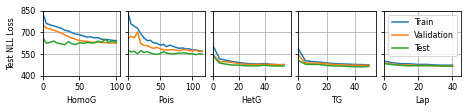

In [14]:
plt.rcParams.update({'font.size': 8})

teststss = ['200302']#,'200316','200608','201012']
testedss = ['200315']#,'200329','200621','201025']

dataset = "rail_catchment"
dist_saves = ['norm_homo', 'poisson', 'norm', 'tnorm', 'laplace']#,'mcdrop' ]

model_type = 'GCN'
iis = [0,2,8,8,8]

model_type = 'GAT'
iis = [1,0,0,3,0]

# iis = [5,1,6,6,1]#,5]
# dataset = 'census_tract'

fig, ax = plt.subplots(1,5, figsize=(7.5, 1.2), sharey=True)
i = 0
for testst, tested in zip(teststss, testedss):
    for ii, dist_save in zip(iis, dist_saves):
#         if dataset == 'rail_catchment':
#             if dist_save == 'norm_homo':
#                 save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"0.5/"
#             else:
#                 save_dir = model_dir+out_folder+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"/"
#         else:
        if dist_save == 'norm_homo':
            save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"0.5/"
        else:
            save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"/"
        save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii)+"_*.pt"
        
        tr, val, te = util_eval.get_loss_curves(save_dir)
        ax[i].plot(tr, label='Train')
        ax[i].plot(val, label='Validation')
        ax[i].plot(te, label='Test')
        ax[i].set_ylim([400,850])
        ax[i].set_yticks(np.arange(400, 851, 150))
        ax[i].set_xlim([0,len(tr)])
        if len(tr) > 15:
            ax[i].set_xticks(np.arange(0,len(tr),10))
            ax[i].set_xticklabels(np.arange(0,5*len(tr),50))
        else:
            ax[i].set_xticks(np.arange(0,len(tr),4))
            ax[i].set_xticklabels(np.arange(0,5*len(tr),20))

        ax[i].grid()
        ax[i].set_xlabel(dist_table[dist_save])
        i += 1
ax[0].set_ylabel("Test NLL Loss")
fig.subplots_adjust(wspace=0.1)
ax[i-1].legend()

fig.savefig(project_dir+"results/R1_rail_190801-200301_200302-200315/combined_training_curve_gat.png", bbox_inches='tight')

## Performance Table and Calibration Plot

### GCN

HomoG-GCN & 218.8 & 0.180 & 33.22 & 98.8\% & 4.24 & 191\% \\
Pois-GCN & 184.6 & 0.344 & 5.73 & 75.6\% & 3.55 & 160\% \\
HetG-GCN & 165.2 & 0.291 & 11.89 & 88.1\% & 4.4 & 198\% \\
TG-GCN & 163.4 & 0.114 & 13.04 & 97.1\% & 2.96 & 133\% \\


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Lap-GCN & 148.3 & 0.217 & 13.41 & 96.7\% & 3.7 & 167\% \\
GEns-GCN & 162.4 & 0.286 & 11.94 & 89.9\% & 4.2 & 189\% \\
\midrule


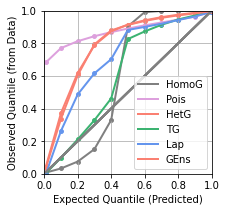

In [66]:
teststss = ['200316']#['200302','200316','200608','201012']
testedss = ['200329']#['200315','200329','200621','201025']

model_type = 'GCN'
dist_saves = ['norm_homo', 'poisson', 'norm', 'tnorm', 'laplace','norm_ens']#,'mcdrop' ]

# iis = [0,2,7,4,6,[7,5,4,6,3]]#,0]
# dataset = 'rail_catchment'

# dist_saves = ['norm_homo','norm','tnorm']
iis = [1,3,4,3,3,[4,3,7,6,5]]
dataset = 'census_tract'

# fig, ax = plt.subplots(figsize=(3,3))

for testst, tested in zip(teststss, testedss):
#     print('\\midrule')
#     print('\\multicolumn{7}{c}{'+period_table[testst]+'}\\\\')
#     print('\\midrule')
    
    fig, ax = plt.subplots(figsize=(3,3))

    for ii, dist_save in zip(iis, dist_saves):
        
        if dist_save == 'norm_ens':
            
            mean_list = []
            var_list = []
            for i in ii:
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_norm/"
                save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"\
                            +str(lookback)+"_"+str(i)+"_*.pt"
            
                output_mean, output_var, target = util_eval.load_and_run(dataset, model_type, 'norm', i, save_dir, trainst, trained, testst, tested, time_size, predict_hzn, std=None)
                mean_list.append(output_mean)
                var_list.append(output_var)
                
            # calculate ensembled stats                     
            ens_mean = np.mean(np.array(mean_list), axis=0)
            ens_var = np.sqrt(np.mean(np.power(np.array(mean_list),2) \
                    + np.power(np.array(var_list),2), axis=0)\
                    - np.power(ens_mean,2))
            
            test_loss, cal_error, mpiw, picp, test_mae, test_mape = eval_cal(ens_mean, output_var, target, 
                                                                             'norm', ax=ax, label=dist_table[dist_save])

        elif dist_save == 'mcdrop':
            save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_norm_homo0.5/"
            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii)+"_*.pt"
            
            # load and run multiple times
            
            output_mean, _, target = util_eval.load_and_run(dataset, model_type, dist_save, ii, save_dir, 
                                                            trainst, trained, testst, tested, time_size, predict_hzn, std=None)
            
                
            mcdrop_lb = np.percentile(np.array(output_mean), 2.5, axis=0)
            mcdrop_ub = np.percentile(np.array(output_mean), 97.5, axis=0)
            mcdrop_mean = np.mean(np.array(output_mean), axis=0)
            
            test_mae, test_mape, _ = util_eval.eval_mean(mcdrop_mean, target, "")
            mpiw, picp = util_eval.eval_pi(mcdrop_lb, mcdrop_ub, target)
            test_loss = -1
            cal_error = -1
            
        else: 
            if dist_save == 'norm_homo':
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"0.5/"
            else:
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"/"
            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii)+"_*.pt"
            # normal procedure
            output_mean, output_var, target = util_eval.load_and_run(dataset, model_type, dist_save, ii, save_dir, trainst, trained, testst, tested, time_size, predict_hzn, std=None)
            test_loss, cal_error, mpiw, picp, test_mae, test_mape = eval_cal(output_mean, output_var, target, 
                                                                             dist_save, ax=ax, label=dist_table[dist_save])

        print('%s & %.4g & %.3f & %.4g & %.3g\\%% & %.3g & %.3g\\%% \\\\' % (dist_table[dist_save]+'-'+model_type, 
                                                                    test_loss, cal_error, mpiw, picp*100, test_mae, test_mape*100))
    print('\midrule')
    ax.grid()
    
#     fig.savefig(project_dir+"results/R1_"+dataset.split("_")[0]+"_190801-200301_200302-200315/"+testst+"_"+model_type+".png", bbox_inches='tight')


### GAT

\midrule
\multicolumn{7}{c}{Immediately Before (March 2 to March 15, 2020)}\\
\midrule
HomoG-GAT & 230.7 & 0.112 & 43.26 & 96.9\% & 6.52 & 28.2\% \\
Pois-GAT & 214.9 & 0.093 & 15.62 & 82\% & 6.06 & 26.3\% \\
HetG-GAT & 188.3 & 0.041 & 31.43 & 95.7\% & 6.07 & 26.3\% \\
TG-GAT & 199.9 & 0.024 & 32.54 & 95.7\% & 6.55 & 28.4\% \\
Lap-GAT & 189.5 & 0.021 & 36.08 & 96.5\% & 6.16 & 26.7\% \\
GEns-GAT & 188.1 & 0.044 & 32.28 & 96\% & 6.18 & 26.8\% \\
\midrule
\midrule
\multicolumn{7}{c}{Stay-at-home (March 16 - March 29, 2020)}\\
\midrule
HomoG-GAT & 218.5 & 0.175 & 34.05 & 99.2\% & 4.8 & 216\% \\
Pois-GAT & 222.7 & 0.368 & 5.764 & 69.2\% & 4.49 & 202\% \\
HetG-GAT & 149.9 & 0.246 & 12.78 & 93.6\% & 4.13 & 186\% \\
TG-GAT & 171.4 & 0.155 & 13.09 & 95.5\% & 3.84 & 173\% \\
Lap-GAT & 148.2 & 0.219 & 14.72 & 96.5\% & 4.23 & 191\% \\
GEns-GAT & 152.2 & 0.255 & 12.74 & 92.2\% & 4.06 & 183\% \\
\midrule
\midrule
\multicolumn{7}{c}{Initial Recovery (June 8 - June 21, 2020)}\\
\midrule
HomoG-GAT & 212

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Lap-GAT & 224.4 & 0.137 & 8.978 & 80.5\% & 2.42 & 62.3\% \\
GEns-GAT & 152.7 & 0.045 & 9.777 & 91.3\% & 2.28 & 58.8\% \\
\midrule
\midrule
\multicolumn{7}{c}{Steady Recovery (Oct 12 - Oct 25, 2020)}\\
\midrule
HomoG-GAT & 216.6 & 0.155 & 36.76 & 99.5\% & 4.22 & 50.1\% \\
Pois-GAT & 193 & 0.159 & 9.675 & 78.5\% & 4.1 & 48.7\% \\
HetG-GAT & 172.2 & 0.097 & 17.43 & 93\% & 4.19 & 49.8\% \\
TG-GAT & 187.2 & 0.039 & 18.32 & 93.6\% & 4.35 & 51.7\% \\
Lap-GAT & 170.7 & 0.063 & 19.69 & 94.6\% & 4.08 & 48.5\% \\
GEns-GAT & 169.4 & 0.094 & 18.22 & 94.6\% & 4.15 & 49.3\% \\
\midrule


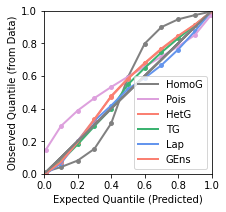

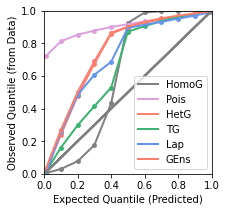

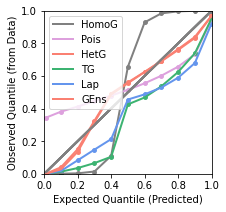

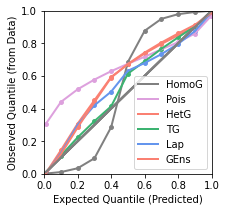

In [42]:
teststss = ['200302','200316','200608','201012']
testedss = ['200315','200329','200621','201025']


model_type = 'GAT'
dist_saves = ['norm_homo', 'poisson', 'norm', 'tnorm', 'laplace','norm_ens','mcdrop', ]

# iis = [1,0,0,3,0,[0,3,1,4,6],1,]
# dataset = "rail_catchment"

iis = [4,2,1,0,2,[1,0,2,3,5]]
dataset = "census_tract"

for testst, tested in zip(teststss, testedss):
    print('\\midrule')
    print('\\multicolumn{7}{c}{'+period_table[testst]+'}\\\\')
    print('\\midrule')
    
    fig, ax = plt.subplots(figsize=(3,3))

    for ii, dist_save in zip(iis, dist_saves):
        if dist_save == 'norm_ens':
            
            mean_list = []
            var_list = []
            for i in ii:
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_norm/"
                save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"\
                            +str(lookback)+"_"+str(i)+"_*.pt"
            
                output_mean, output_var, target = util_eval.load_and_run(dataset, model_type, 'norm', i, save_dir, trainst, trained, testst, tested, time_size, predict_hzn, std=None)
                mean_list.append(output_mean)
                var_list.append(output_var)
                
            # calculate ensembled stats                     
            ens_mean = np.mean(np.array(mean_list), axis=0)
            ens_var = np.sqrt(np.mean(np.power(np.array(mean_list),2) \
                    + np.power(np.array(var_list),2), axis=0)\
                    - np.power(ens_mean,2))
            
            test_loss, cal_error, mpiw, picp, test_mae, test_mape = eval_cal(ens_mean, output_var, target, 'norm', 
                                                                             ax=ax, label=dist_table[dist_save])

        elif dist_save == 'mcdrop':
            save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_norm_homo0.5/"
            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii)+"_*.pt"
            
            # load and run multiple times
            
            output_mean, _, target = util_eval.load_and_run(dataset, model_type, dist_save, ii, save_dir, trainst, trained, testst, tested, time_size, predict_hzn, std=None)
            
                
            mcdrop_lb = np.percentile(np.array(output_mean), 2.5, axis=0)
            mcdrop_ub = np.percentile(np.array(output_mean), 97.5, axis=0)
            mcdrop_mean = np.mean(np.array(output_mean), axis=0)
            
            test_mae, test_mape, _ = util_eval.eval_mean(mcdrop_mean, target, "")
            mpiw, picp = util_eval.eval_pi(mcdrop_lb, mcdrop_ub, target)
            test_loss = -1
            cal_error = -1
            
        else: 
            if dist_save == 'norm_homo':
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"0.5/"
            else:
                save_dir = model_dir+out_folder+"_"+dataset.split("_")[0]+"_"+trainst+"-"+trained+"_"+model_type+"_"+dist_save+"/"
            
            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii)+"_*.pt"

            # normal procedure
            output_mean, output_var, target = util_eval.load_and_run(dataset, model_type, dist_save, ii, save_dir, trainst, trained, testst, tested, time_size, predict_hzn, std=None)
            test_loss, cal_error, mpiw, picp, test_mae, test_mape = eval_cal(output_mean, output_var, target, dist_save, 
                                                                             ax=ax, label=dist_table[dist_save])

        print('%s & %.4g & %.3f & %.4g & %.3g\\%% & %.3g & %.3g\\%% \\\\' % (dist_table[dist_save]+'-'+model_type, 
                                                                    test_loss, cal_error, mpiw, picp*100, test_mae, test_mape*100))
    print('\midrule')
    
    if dataset == 'rail_catchment':
        fig.savefig(project_dir+"results/R1_rail_190801-200301_200302-200315/"+testst+"_"+model_type+".png", bbox_inches='tight')
    else:
        fig.savefig(project_dir+"results/R1_census_190801-200301_200302-200315/"+testst+"_"+model_type+".png", bbox_inches='tight')
